In [2]:
# %load utils.py
import keras
from keras.layers import MaxPooling2D, UpSampling2D, Input
from keras.layers import Multiply, Lambda, Concatenate, Reshape, Lambda
from PIL import Image
import keras.backend as K
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from keras.preprocessing import image
from imagenet_utils import preprocess_input, decode_predictions
from scipy.io import loadmat

#2 simple functions to visualize an image predicted by the model
#https://github.com/erikreppel/visualizing_cnns/blob/master/visualize_cnns.ipynb
def visualize_image(model, myimage, dim=None, compare=0, figure=None):
    myimage_batch = np.expand_dims(myimage,axis=0)
    conv_myimage = model.predict(myimage_batch)
    conv_myimage = np.squeeze(conv_myimage, axis=0)
    if dim:
        conv_myimage = sp.misc.imresize(conv_myimage, dim)
    print conv_myimage.shape
    if compare == 1:
        two_images(myimage, conv_myimage, figure)
    if compare == 0:
        plt.imshow(conv_myimage)
    return conv_myimage

def keras_predict(model, img):
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)
    return model.predict(x)

def keras_visualize(img):
    img = np.squeeze(img,axis=0)
    plt.imshow(img)
    return img

def keras_open_image(img_path, target_size=(224,224)):
    #rgbImage = Image.open(myimage).convert('RGB')
    #ret_image = np.array(rgbImage)
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    return x

def open_image(myimage, resize=None):
    rgbImage = Image.open(myimage).convert('RGB')
    if resize != None:
        rgbImage = sp.misc.imresize(rgbImage, resize)
    return np.array(rgbImage)

#look at differences between two carved images
def same_output(model1, model2, image):
    figure = plt.figure()
    figure.add_subplot(1,2,1)
    im1 = visualize_image(model1, image)
    figure.add_subplot(1,2,2)
    im2 = visualize_image(model2, image)
    return np.array_equal(im1,im2)

def two_images(image1, image2, figure=None):
    if figure == None:
        figure = plt.figure()
    figure.add_subplot(1,2,1)
    plt.imshow(image1)
    figure.add_subplot(1,2,2)
    plt.imshow(image2)

def res_visualize_image(model, myimage, dim):
    myimage_batch = np.expand_dims(myimage,axis=0)
    conv_myimage = model.predict(myimage_batch)
    conv_myimage = np.squeeze(conv_myimage, axis=0)
    print conv_myimage.shape
    plt.imshow(conv_myimage)
    return conv_myimage

# Function to nicely print segmentation results with
# colorbar showing class names
def discrete_matshow(data, labels_names=[], title=""):

    fig_size = [7, 6]
    plt.rcParams["figure.figsize"] = fig_size

    #get discrete colormap
    cmap = plt.get_cmap('Paired', np.max(data)-np.min(data)+1)

    # set limits .5 outside true range
    mat = plt.imshow(data,
                      cmap=cmap,
                      vmin = np.min(data)-.5,
                      vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat,
                       ticks=np.arange(np.min(data),np.max(data)+1))

    # The names to be printed aside the colorbar
    if labels_names:
        cax.ax.set_yticklabels(labels_names)

    if title:
        plt.suptitle(title, fontsize=15, fontweight='bold')
def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """

    filter_size = get_kernel_size(factor)

    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)

    upsample_kernel = upsample_filt(filter_size)

    for i in xrange(number_of_classes):

        weights[:, :, i, i] = upsample_kernel

    return weights


Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda0: GeForce GTX 1060 6GB (0000:01:00.0)


In [5]:
#ho aggiunto gli ultimi due layer(che comunque avevamo già provato) per fare l'associazione con i pesi trovati qui: 
#http://www.vlfeat.org/matconvnet/pretrained/

from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Conv2DTranspose, Cropping2D

def FCN(stop=False, input_shape=None):
    inputData = Input(batch_shape=(None,224,224,3))
    #First Layer
    conv1_1 = Conv2D(64,kernel_size=(3,3),activation='relu',padding='same', name='conv1_1')(inputData)
    conv1_2 = Conv2D(64,kernel_size=(3,3),activation='relu',padding='same', name='conv1_2')(conv1_1)
    pool1 = MaxPooling2D((2,2), strides=(2,2), name='block1_pool')(conv1_2)
    #Second Convolution
    conv2_1 = Conv2D(128,kernel_size=(3,3),activation='relu',padding='same', name='conv2_1')(pool1)
    conv2_2 = Conv2D(128,kernel_size=(3,3),activation='relu',padding='same', name='conv2_2')(conv2_1)
    pool2 = MaxPooling2D((2,2), strides=(2,2), name='block2_pool')(conv2_2)
    #Third Convolution
    conv3_1 = Conv2D(256,kernel_size=(3,3),activation='relu',padding='same', name='conv3_1')(pool2)
    conv3_2 = Conv2D(256,kernel_size=(3,3),activation='relu',padding='same', name='conv3_2')(conv3_1)
    conv3_3 = Conv2D(256,kernel_size=(3,3),activation='relu',padding='same', name='conv3_3')(conv3_2)
    pool3 = MaxPooling2D((2,2), strides=(2,2), name='block3_pool')(conv3_3)
    #Fourth Convolution
    conv4_1 = Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', name='conv4_1')(pool3)
    conv4_2 = Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', name='conv4_2')(conv4_1)
    conv4_3 = Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', name='conv4_3')(conv4_2)
    pool4 = MaxPooling2D((2,2), strides=(2,2), name='block4_pool')(conv4_3)
    #Fifth Convolution
    conv5_1 = Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', name='conv5_1')(pool4)
    conv5_2 = Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', name='conv5_2')(conv5_1)
    conv5_3 = Conv2D(512,kernel_size=(3,3),activation='relu',padding='same', name='conv5_3')(conv5_2)
    pool5 = MaxPooling2D((2,2), strides=(2,2), name='block5_pool')(conv5_3)
    #Fully Convolutional Layers 32s
    fc6 = Conv2D(4096,kernel_size=(7,7),activation='relu',padding='same', name='fc6')(pool5)
    drop6 = Dropout(0.5)(fc6)
    fc7 = Conv2D(4096,kernel_size=(1,1),activation='relu',padding='same', name='fc7')(drop6)
    drop7 = Dropout(0.5)(fc7)
    #score_fr = Conv2D(21,kernel_size=(1,1),padding='valid')(drop7)
    score_fr = Conv2D(21, kernel_size=(1,1), padding='valid', name='score_fr')(drop7)
    #Deconv Layer
    #flat = Flatten()(upscore)
    #pred32 = Dense(21,activation='softmax')(flat)
    #upscore = Conv2DTranspose(3,kernel_size=(64,64),strides=(32,32),use_bias=False)(score_fr)

    bil = Conv2DTranspose(21, kernel_size=(64,64),strides=(32,32), name='upsample')(score_fr)
    crop = Cropping2D(cropping=16)(bil)
    #bilinear_lambda = Lambda(bilfunction, output_shape=(224,224,3))(score_fr)
    #bu = Lambda(lambda x:theano.tensor.nnet.abstract_conv.bilinear_upsampling(x,32), output_shape=(224,224,3))(score_fr)
    model = Model(inputs=inputData, outputs=[crop])
    #model.load_weights('/home/afagnani/keras-deconvnet/fcn.h5', by_name=True)
    #bilW = bilinear_upsample_weights(32,1000)
    #model.layers[-1].set_weights([bilW])
    return model


In [6]:
model = FCN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
#aggiungo i pesi
            
data = loadmat('pascal-fcn32s-dag.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
p = data['params']
description = data['meta'][0,0].classes[0,0].description


def copy_mat_to_keras(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]
    for i in range(0, p.shape[1]-1, 2):
        matname = '_'.join(p[0,i].name[0].split('_')[0:-1])
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print 'found : ', (str(matname), kindex)
            l_weights = p[0,i].value
            l_bias = p[0,i+1].value
            kmodel.layers[kindex].set_weights([l_weights, l_bias[:,0]])
        else:
            print 'not found : ', str(matname)

            
copy_mat_to_keras(model)

found :  ('conv1_1', 1)
found :  ('conv1_2', 2)
found :  ('conv2_1', 4)
found :  ('conv2_2', 5)
found :  ('conv3_1', 7)
found :  ('conv3_2', 8)
found :  ('conv3_3', 9)
found :  ('conv4_1', 11)
found :  ('conv4_2', 12)
found :  ('conv4_3', 13)
found :  ('conv5_1', 15)
found :  ('conv5_2', 16)
found :  ('conv5_3', 17)
found :  ('fc6', 19)
found :  ('fc7', 21)
found :  ('score_fr', 23)
found :  ('upsample', 24)


In [10]:
#il dataset riconosce queste classi
class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i
    
print(sorted(class2index.keys()))

['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


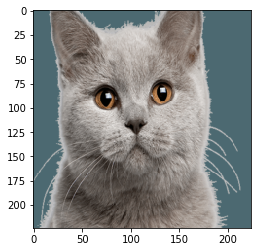

In [18]:
#prendo la solita immagine
catorig = open_image('cat.png', resize=(224,224,3))
%matplotlib inline
plt.imshow(catorig)

In [19]:
#modifico l'immagine in base ai parametri che anche lei ha trovato

def prepareim(im):
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    im = np.expand_dims(im, axis=0)
    return im

cat = catorig.astype('float64')
catp = prepareim(cat)

In [20]:
preds = model.predict(catp)
imclass = np.argmax(preds, axis=3)[0,:,:]

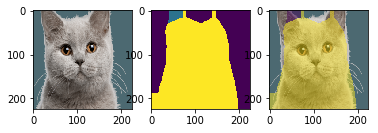

In [21]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(catorig)
plt.subplot(1,3,2)
plt.imshow(imclass)
plt.subplot(1,3,3)
plt.imshow(catorig)
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow(masked_imclass, alpha=0.5)

In [22]:
#lista delle classi trovate
for c in np.unique(imclass):
    if c < 22:
        print c, str(description[0,c][0])

0 background
3 bird
8 cat


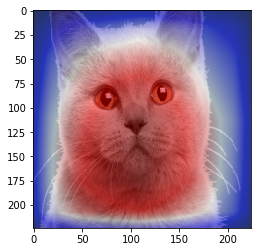

In [30]:
#dove vede il gatto
plt.imshow(catorig)
plt.imshow(preds[0,:,:,class2index['cat']], cmap='seismic', alpha=0.5)

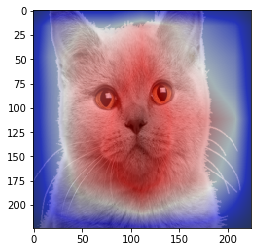

In [31]:
#dove vede un uccello
plt.imshow(catorig)
plt.imshow(preds[0,:,:,class2index['bird']], cmap='seismic', alpha=0.5)

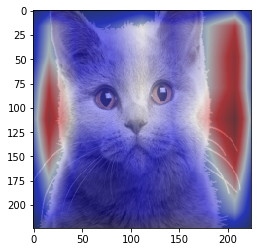

In [32]:
#dove vede il background
plt.imshow(catorig)
plt.imshow(preds[0,:,:,class2index['background']], cmap='seismic', alpha=0.5)